In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import sqlite3
import csv
from datetime import datetime as dt

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [ ]:
conn = sqlite3.connect("../db.sqlite3")
cursor = conn.cursor()
cursor.execute(
    "select * from restaurant_orderitem inner join restaurant_order on restaurant_orderitem.order_id = restaurant_order.id inner join restaurant_product on restaurant_orderitem.product_id = restaurant_product.id"
)
with open("data.csv", "w", newline="") as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow([i[0] for i in cursor.description])
    csv_writer.writerows(cursor)
conn.close()

In [245]:
df = pd.read_csv("data.csv")
df["datetime"] = pd.to_datetime(df["datetime"], format="%Y-%m-%d %H:%M:%S")
df.drop(columns=["id.1", "id.2", "product_id", "order_id"], inplace=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74818 entries, 0 to 74817
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        74818 non-null  int64         
 1   quantity  74818 non-null  int64         
 2   datetime  74818 non-null  datetime64[ns]
 3   price     74818 non-null  float64       
 4   name      74818 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 2.9+ MB


,id,quantity,datetime,price,name
0,1,2,2019-08-03 20:25:00,0.80,Plain Papadum
1,2,1,2019-08-03 20:25:00,12.95,King Prawn Balti
2,3,1,2019-08-03 20:25:00,2.95,Garlic Naan
3,4,1,2019-08-03 20:25:00,3.95,Mushroom Rice
4,5,1,2019-08-03 20:25:00,8.95,Paneer Tikka Masala


# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

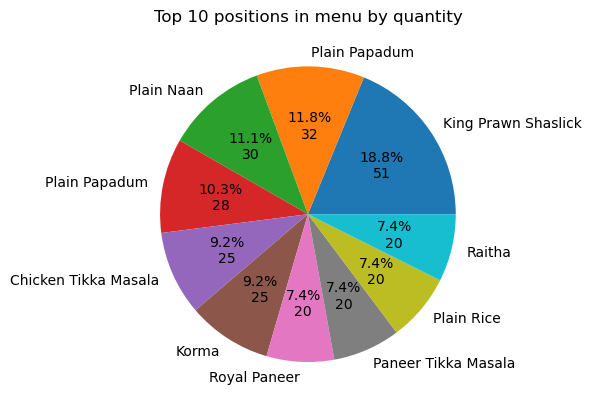

In [246]:
new_df = df.sort_values(by="quantity", ascending=False)[:10]

slice = new_df["quantity"]
activities = new_df["name"]


def func(pct, allvals):
    absolute = int(np.round(pct / 100.0 * np.sum(allvals)))
    return "{:.1f}%\n{:d}".format(pct, absolute)


plt.pie(slice, labels=activities, autopct=lambda pct: func(pct, slice))
plt.title("Top 10 positions in menu by quantity")
plt.show()

# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

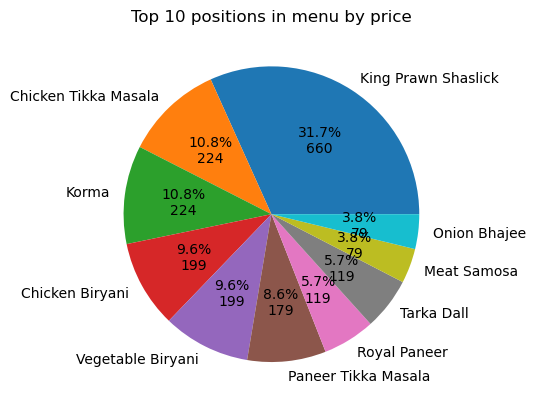

In [247]:
df["item-price"] = df["quantity"] * df["price"]
new_df = df.sort_values(by="item-price", ascending=False)[:10]

slice = new_df["item-price"]
activities = new_df["name"]


def func2(pct, allvals):
    absolute = int(np.round(pct / 100.0 * np.sum(allvals)))
    return "{:.1f}%\n{:d}".format(pct, absolute)


plt.pie(slice, labels=activities, autopct=lambda pct: func2(pct, slice))
plt.title("Top 10 positions in menu by price")
plt.show()

# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

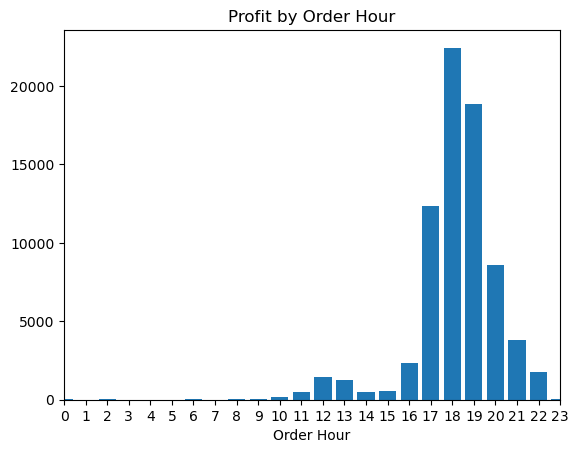

In [248]:
df["time_hour"] = df["datetime"].dt.hour

hours = df.groupby("time_hour").count().iloc[:, :1]
dct = list(hours.to_dict().values())[0]

fig, ax = plt.subplots()
ax.bar(dct.keys(), dct.values())

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.xlim([0, 23])
plt.xlabel("Order Hour")
plt.title("Profit by Order Hour")
plt.show()

# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

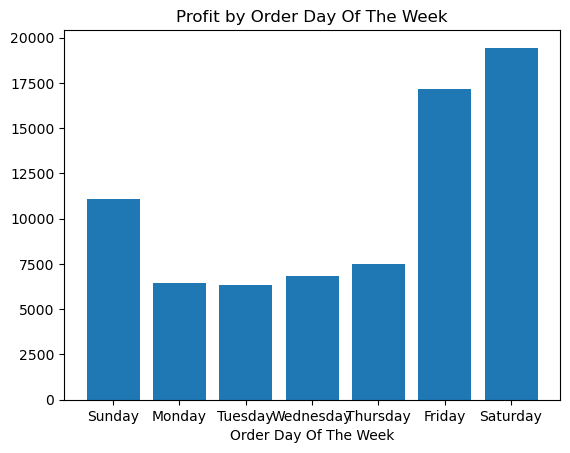

weekday
Friday       100339.15
Monday        40008.30
Saturday     112191.65
Sunday        67105.95
Thursday      46021.55
Tuesday       38145.65
Wednesday     41246.20
Name: item-price, dtype: float64

In [249]:
df["weekday"] = df["datetime"].dt.strftime("%A")
df["item-price"] = df["quantity"] * df["price"]


cats = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

days = df.groupby(["weekday"]).count().reindex(cats).iloc[:, :1]
dct = list(days.to_dict().values())[0]

plt.bar(dct.keys(), dct.values())

plt.xlabel("Order Day Of The Week")
plt.title("Profit by Order Day Of The Week")
plt.show()

df.groupby(["weekday"]).sum()["item-price"]